In [119]:
from typing import Dict, Tuple
import os

import torch
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.ppo import APPOTrainer
from ray.rllib.agents.a3c import A3CTrainer
from ray.rllib.agents.sac import SACTrainer
from ray.rllib.agents.impala import ImpalaTrainer
from ray.rllib.agents.dqn import R2D2Trainer
from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.policy import Policy
from ray.rllib.policy.sample_batch import SampleBatch

import gym
from gym import wrappers
import ray
import numpy as np
from scipy.interpolate import interp1d
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchsummary import summary
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# # ## for Palatino and other serif fonts use:
# # #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import io
import base64
from IPython.display import HTML

from src.envs.multiple_particles_in_flow_continuous import MultipleParticlesInFlowContinuous
from src.envs.multiple_particles_in_flow_discrete import MultipleParticlesInFlowDiscrete
from src.envs.multiple_particles_in_flow_delayed_obs_continuous import MultipleParticlesInFlowDelayedObsContinuous
from src.envs.multiple_particles_in_flow_delayed_obs_discrete import MultipleParticlesInFlowDelayedObsDiscrete

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global Configurations

In [120]:
random_seed = 102
test_name = "act_cost_10_n_cells_1_1"

In [121]:
global_env_config = {
    "dt": 0.1,
    "xc": 9.0,
    "yc": 0.0,
    "sigma_x": 0.6,
    "sigma_y": 0.5,
    "gain": 0.25,
    "act_cost_weight": 10.0,
    "obs_min": [7.0, 0.1],
    "obs_max": [8.0, 0.5],
    "n_particles": 400,
    "lamb": 0.1,
    "n_cells": [1,1]
}

In [122]:
def test_and_plot(env, policy, lstm=False):
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0

    obs_hist = [obs]
    particle_hist = [env.cur_particles]
    state_hist = [env.cur_state]
    action_hist = []
    if lstm:
        lstm_state = [np.zeros([lstm_cell_size], np.float32) for _ in range(2)]
        lstm_state_hist = [lstm_state]
    action = [0]

    while not done:
        if lstm:
            action, lstm_state, _ = policy(obs, lstm_state, explore=False)
        else:
            action = policy(obs, explore=False)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        step += 1
        obs_hist.append(obs)
        action_hist.append(action)
        particle_hist.append(env.cur_particles)
        state_hist.append(env.cur_state)
        if lstm:
            lstm_state_hist.append(lstm_state)

    print(f"Played 1 episode; total-reward={total_reward}; Number of steps: {step}")

    particle_hist = np.array(particle_hist)
    state_hist = np.array(state_hist)
    action_hist = np.array(action_hist)
    obs_hist = np.array(obs_hist)

    act_x, act_y = np.meshgrid(np.linspace(0,15,151),np.linspace(0,1.2,15))
    act_mag = env.jet_dist(act_x, act_y)

    fig = plt.figure(figsize=(16,8))

    ax = fig.add_subplot(211)
    ax.plot(particle_hist[:,:,0], particle_hist[:,:,1], c='r', lw=0.1)
    ax.scatter(particle_hist[0,:,0], particle_hist[0,:,1], s=5, c='r')
    ax.scatter(particle_hist[-1,:,0], particle_hist[-1,:,1], s=5, c='r')
    ax.plot(state_hist[:,0], state_hist[:,1], c='darkred', lw=2)
    # ax.plot(obs_hist[:,0], obs_hist[:,1], c='r', label='Observation')
    # ax.plot(action_region_x, action_region_y, c='orange', label='Force Field')
    ax.contourf(act_x, act_y, act_mag, vmin=-1.6, vmax=1.5, cmap='RdBu', zorder=-10)
    ax.plot(state_hist[:-1,0], action_hist, c='k', label='Action')
    ax.grid(True)
    ax.set_aspect('equal', 'box')
    ax.set_xlim([0,15])
    ax.set_ylim([0,1.2])

    ax = fig.add_subplot(212)
    ax.plot(action_hist, c='k', label='Action')
    ax.plot(state_hist[:-1,1], c='darkred', label='Mean y')
    ax.plot(obs_hist, c='b', label='Action')
    ax.set_xlim([0,200])
    ax.set_ylim([0,1.2])
    ax.grid()
    
    return ax

In [123]:
def plot_results(train_episodes, train_reward, train_downwash, train_actuation):
    fig = plt.figure(figsize=[16,4])
    ax = fig.add_subplot(131)
    ax.plot(train_episodes, train_reward, c='r', label='Average Reward')
    ax.legend()
    ax.grid()

    ax = fig.add_subplot(132)
    ax.plot(train_episodes, train_downwash, c='b', label='Average Downwash')
    ax.legend()
    ax.grid()

    ax = fig.add_subplot(133)
    ax.plot(train_episodes, train_actuation, c='k', label='Average Actuation')
    ax.legend()
    ax.grid()
    
    return ax

In [124]:
def const_policy_cont(a, explore=False):
    return [1]
def const_policy_disc(a, explore=False):
    return 1

## Callbacks

In [125]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).
        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["reward_downwash"] = []
        episode.hist_data["reward_downwash"] = []
        episode.user_data["reward_actuation"] = []
        episode.hist_data["reward_actuation"] = []
        
    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Make sure this episode is ongoing.
        assert episode.length > 0, (
            "ERROR: `on_episode_step()` callback should not be called right "
            "after env reset!"
        )
        reward_downwash = base_env.get_sub_environments()[0].cur_reward_downwash
        reward_actuation = -base_env.get_sub_environments()[0].cur_reward_actuation

        episode.user_data["reward_downwash"].append(reward_downwash)
        episode.user_data["reward_actuation"].append(reward_actuation)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Check if there are multiple episodes in a batch, i.e.
        # "batch_mode": "truncate_episodes".
        if worker.policy_config["batch_mode"] == "truncate_episodes":
            # Make sure this episode is really done.
            assert episode.batch_builder.policy_collectors["default_policy"].batches[
                -1
            ]["dones"][-1], (
                "ERROR: `on_episode_end()` should only be called "
                "after episode is done!"
            )
        reward_downwash = np.mean(episode.user_data["reward_downwash"])
        reward_actuation = np.mean(episode.user_data["reward_actuation"])

        episode.custom_metrics["reward_downwash"] = reward_downwash
        episode.custom_metrics["reward_actuation"] = reward_actuation
        episode.hist_data["reward_downwash"] = episode.user_data["reward_downwash"]
        episode.hist_data["reward_actuation"] = episode.user_data["reward_actuation"]

# Domain Overview Plot

Played 1 episode; total-reward=-227.69208129317028; Number of steps: 162


<IPython.core.display.Javascript object>


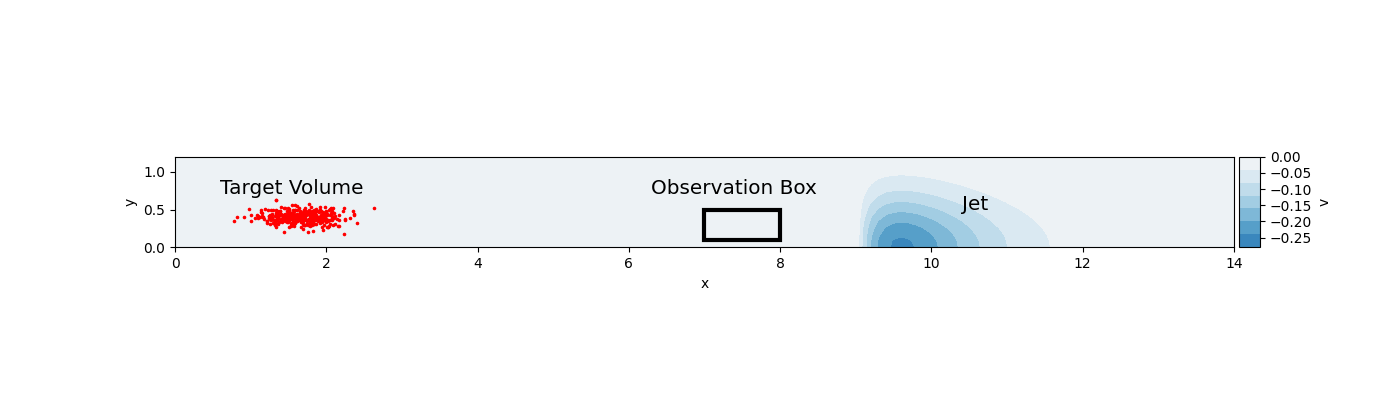

In [126]:
np.random.seed(17)

env_config = global_env_config.copy()
env = MultipleParticlesInFlowDiscrete(config=env_config)

obs = env.reset()
done = False
total_reward = 0
step = 0

obs_hist = [obs]
particle_hist = [env.cur_particles]
state_hist = [env.cur_state]
action_hist = []
# if lstm:
#     lstm_state = [np.zeros([lstm_cell_size], np.float32) for _ in range(2)]
#     lstm_state_hist = [lstm_state]
action = [0]

while not done:
#     if lstm:
#         action, lstm_state, _ = policy(obs, lstm_state, explore=False)
#     else:
#         action = policy(obs, explore=False)
    action = 1
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    step += 1
    obs_hist.append(obs)
    action_hist.append(action)
    particle_hist.append(env.cur_particles)
    state_hist.append(env.cur_state)
#     if lstm:
#         lstm_state_hist.append(lstm_state)

print(f"Played 1 episode; total-reward={total_reward}; Number of steps: {step}")

particle_hist = np.array(particle_hist)
state_hist = np.array(state_hist)
action_hist = np.array(action_hist)
obs_hist = np.array(obs_hist)

act_x, act_y = np.meshgrid(np.linspace(0,16,161),np.linspace(0,1.2,15))
uy = -global_env_config["gain"] * env.jet_dist(act_x, act_y)

# fig = plt.figure(figsize=(14,4))
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

# ax.plot(particle_hist[:,:,0], particle_hist[:,:,1], c='r', lw=0.1)
ax.scatter(particle_hist[0,:,0], particle_hist[0,:,1], s=2.5, c='r')
# ax.scatter(particle_hist[-1,:,0], particle_hist[-1,:,1], s=5, c='r')
# ax.plot(state_hist[:,0], state_hist[:,1], c='darkred', lw=2)
# ax.plot(obs_hist[:,0], obs_hist[:,1], c='r', label='Observation')
# ax.plot(action_region_x, action_region_y, c='orange', label='Force Field')
cont = ax.contourf(act_x, act_y, uy, vmin=-0.4, vmax=0.4, cmap='RdBu_r', zorder=-10)
# ax.plot(state_hist[:-1,0], action_hist, c='k', label='Action')

# Create a Rectangle patch
rect = patches.Rectangle((7, 0.1), 1, 0.4, linewidth=3, edgecolor='k', facecolor='none')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.05)
fig.add_axes(ax_cb)
plt.colorbar(cont, cax=ax_cb, label="v", ticks=[-0.25, -0.2, -0.15, -0.1, -0.05, 0.0])

# cbar = plt.colorbar(cont, cax=ax)

# Add the patch to the Axes
ax.add_patch(rect)

ax.text(0.6, 0.7, "Target Volume", fontsize='x-large')
ax.text(6.3, 0.7, "Observation Box", fontsize='x-large')
ax.text(10.4, 0.5, "Jet", fontsize='x-large')

# ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlim([0,14])
ax.set_ylim([0,1.2])
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.autoscale_view()

# ax = fig.add_subplot(212)
# ax.plot(action_hist, c='k', label='Action')
# ax.plot(state_hist[:-1,1], c='darkred', label='Mean y')
# ax.plot(obs_hist, c='b', label='Action')
# ax.set_xlim([0,200])
# ax.set_ylim([0,1.2])
# ax.grid()

plt.savefig("figs/domain_overview.eps")

# Vector Field

Played 1 episode; total-reward=-227.69208129317028; Number of steps: 162


<IPython.core.display.Javascript object>


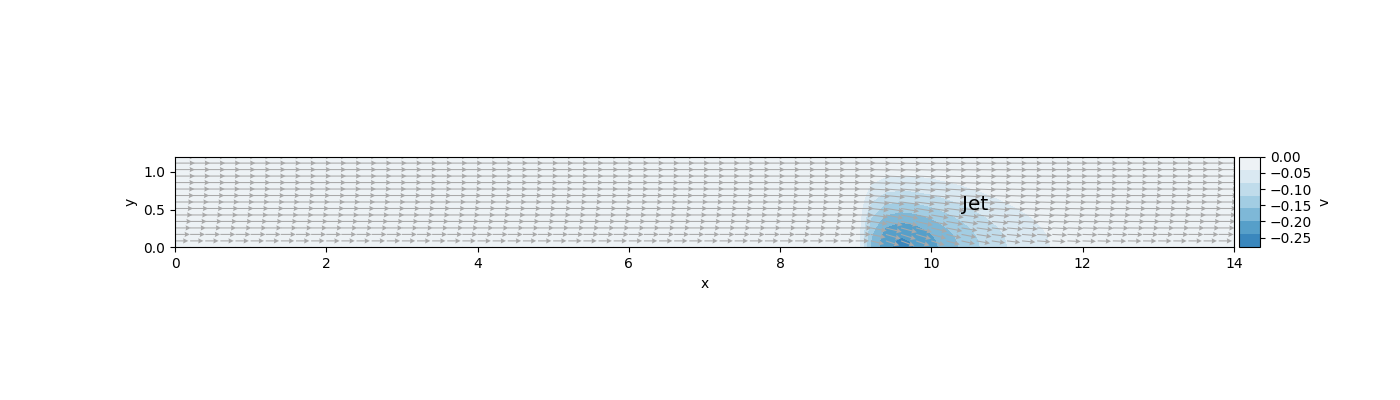

In [127]:
np.random.seed(17)

env_config = global_env_config.copy()
env = MultipleParticlesInFlowDiscrete(config=env_config)

obs = env.reset()
done = False
total_reward = 0
step = 0

obs_hist = [obs]
particle_hist = [env.cur_particles]
state_hist = [env.cur_state]
action_hist = []
# if lstm:
#     lstm_state = [np.zeros([lstm_cell_size], np.float32) for _ in range(2)]
#     lstm_state_hist = [lstm_state]
action = [0]

while not done:
#     if lstm:
#         action, lstm_state, _ = policy(obs, lstm_state, explore=False)
#     else:
#         action = policy(obs, explore=False)
    action = 1
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    step += 1
    obs_hist.append(obs)
    action_hist.append(action)
    particle_hist.append(env.cur_particles)
    state_hist.append(env.cur_state)
#     if lstm:
#         lstm_state_hist.append(lstm_state)

print(f"Played 1 episode; total-reward={total_reward}; Number of steps: {step}")

particle_hist = np.array(particle_hist)
state_hist = np.array(state_hist)
action_hist = np.array(action_hist)
obs_hist = np.array(obs_hist)

# act_x, act_y = np.meshgrid(np.linspace(0,16,161),np.linspace(0.00001,1.2,15))
act_x, act_y = np.meshgrid(np.linspace(0,16,81),np.linspace(0.00001,1.2,15))
ux = env.u_tbl(act_y)
uy = -global_env_config["gain"] * env.jet_dist(act_x, act_y)
u_mag = np.sqrt(ux**2 + uy**2)



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

# ax.scatter(particle_hist[0,:,0], particle_hist[0,:,1], s=2.5, c='r')
cont = ax.contourf(act_x, act_y, uy, vmin=-0.4, vmax=0.4, cmap='RdBu_r', zorder=-10)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.05)
fig.add_axes(ax_cb)
plt.colorbar(cont, cax=ax_cb, label="v", ticks=[-0.25, -0.2, -0.15, -0.1, -0.05, 0.0])

# ax.quiver(act_x.flatten(), act_y.flatten(), ux.flatten(), uy.flatten(), color='gray', 
#           scale=5*u_mag.flatten(), scale_units='x', width=0.001, headwidth=5, zorder=-15)

ax.quiver(act_x.flatten(), act_y.flatten(), ux.flatten(), uy.flatten(), color='darkgray', 
          width=0.001, headwidth=5, zorder=-5)

# Create a Rectangle patch
# rect = patches.Rectangle((7, 0.1), 1, 0.4, linewidth=3, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# ax.text(0.6, 0.7, "Target Volume", fontsize='x-large')
# ax.text(6.3, 0.7, "Observation Box", fontsize='x-large')
ax.text(10.4, 0.5, "Jet", fontsize='x-large')

# ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlim([0,14])
ax.set_ylim([0,1.2])
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.autoscale_view()

# ax = fig.add_subplot(212)
# ax.plot(action_hist, c='k', label='Action')
# ax.plot(state_hist[:-1,1], c='darkred', label='Mean y')
# ax.plot(obs_hist, c='b', label='Action')
# ax.set_xlim([0,200])
# ax.set_ylim([0,1.2])
# ax.grid()

plt.savefig("figs/domain_overview_quiver.eps")

# Animate Policies

In [154]:
def test_and_animate(env, policy, lstm=False, save_as=None):
    obs = env.reset()
    done = False
    total_reward = 0
    step = 0

    obs_hist = [obs]
    particle_hist = [env.cur_particles]
    state_hist = [env.cur_state]
    action_hist = []
    raw_action_hist = [0.0]
    if lstm:
        lstm_state = [np.zeros([lstm_cell_size], np.float32) for _ in range(2)]
        lstm_state_hist = [lstm_state]
    action = [0]

    while not done:
        if lstm:
            action, lstm_state, _ = policy(obs, lstm_state, explore=False)
        else:
            action = policy(obs, explore=False)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        step += 1
        obs_hist.append(obs)
        action_hist.append(action)
        particle_hist.append(env.cur_particles)
        state_hist.append(env.cur_state)
        raw_action_hist.append(env.cur_action)
    #     if lstm:
    #         lstm_state_hist.append(lstm_state)

    print(f"Played 1 episode; total-reward={total_reward}; Number of steps: {step}")

    particle_hist = np.array(particle_hist)
    state_hist = np.array(state_hist)
    action_hist = np.array(action_hist)
    obs_hist = np.array(obs_hist)

    act_x, act_y = np.meshgrid(np.linspace(0,16,161),np.linspace(0,1.2,15))
    uy = -global_env_config["gain"] * env.jet_dist(act_x, act_y)

    # fig = plt.figure(figsize=(20,8))
    # ax = fig.add_subplot(111)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

    cont = ax.contourf(act_x, act_y, uy, vmin=-0.4, vmax=0.4, cmap='RdBu_r', zorder=-10)
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="2%", pad=0.05)
    fig.add_axes(ax_cb)

    def animate(t):
        ax.clear()
        # ax.plot(particle_hist[:,:,0], particle_hist[:,:,1], c='r', lw=0.1)
        ax.scatter(particle_hist[t,:,0], particle_hist[t,:,1], s=2.5, c='r')
        # ax.scatter(particle_hist[-1,:,0], particle_hist[-1,:,1], s=5, c='r')
        # ax.plot(state_hist[:,0], state_hist[:,1], c='darkred', lw=2)
        # ax.plot(obs_hist[:,0], obs_hist[:,1], c='r', label='Observation')
        # ax.plot(action_region_x, action_region_y, c='orange', label='Force Field')
        ax.contourf(act_x, act_y, raw_action_hist[t]*uy, vmin=-0.4, vmax=0.4, cmap='RdBu_r', zorder=-10)
        # ax.plot(state_hist[:-1,0], action_hist, c='k', label='Action')

        # Create a Rectangle patch
        rect = patches.Rectangle((7, 0.1), 1, 0.4, linewidth=3, edgecolor='k', facecolor='none')


        plt.colorbar(cont, cax=ax_cb, label="v", ticks=[-0.25, -0.2, -0.15, -0.1, -0.05, 0.0])

        # Create a Rectangle patch
        rect = patches.Rectangle((7, 0.1), 1, 0.4, linewidth=2, edgecolor='k', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        if t < 20:
            ax.text(0.8, 0.7, "Target Volume", fontsize='x-large')
        ax.text(6.4, 0.7, "Observation Box", fontsize='x-large')
        ax.text(10.4, 0.5, "Jet", fontsize='x-large')

        ax.grid(True)
        ax.set_aspect('equal', 'box')
        ax.set_xlim([0,14])
        ax.set_ylim([0,1.2])
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        act_to_plot = action_hist[t][0] if type(action_hist[t]) == list else action_hist[t]
        ax.set_title(f"Action = {act_to_plot}")
        
        if save_as is not None:
            plt.savefig(f"figs/{save_as}_{t:03d}.png")

        return ax

    anim = animation.FuncAnimation(fig, animate, frames=range(0,len(action_hist),1), interval=40, repeat=False)
    # animate(150)
    
    return anim

Played 1 episode; total-reward=-227.69208129317028; Number of steps: 162


<IPython.core.display.Javascript object>


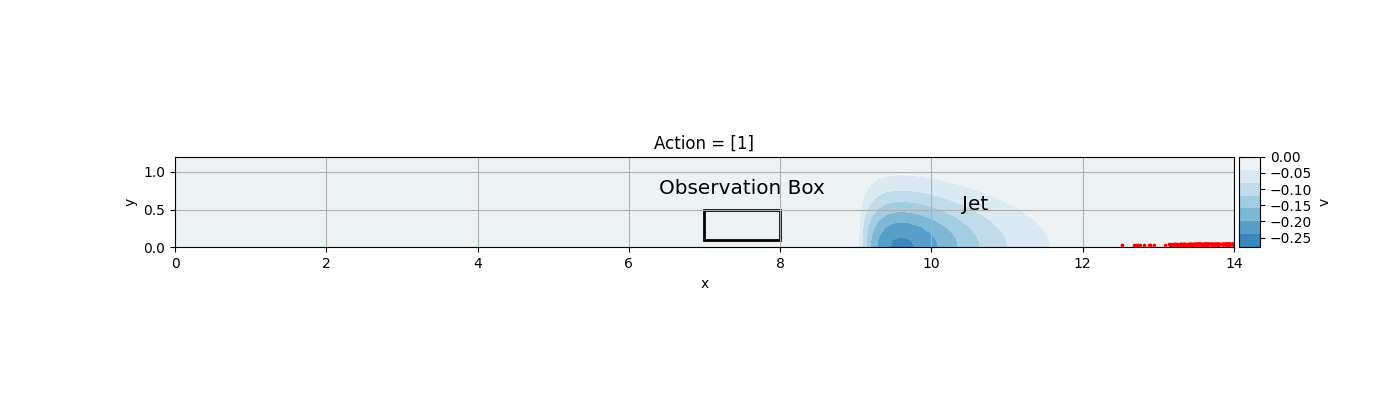

In [155]:
np.random.seed(17)

env_config = global_env_config.copy()
env = MultipleParticlesInFlowContinuous(config=env_config)
test_and_animate(env, const_policy_cont, lstm=False, save_as="domain_always_on")


## PPO + LSTM - Continuous

In [156]:
env_config = global_env_config.copy()

torch.manual_seed(random_seed)
np.random.seed(random_seed)

lstm_cell_size = 16
trainer_ppo_lstm_cont = PPOTrainer(
    config={
        "env": MultipleParticlesInFlowContinuous,
        "env_config": env_config,
        "framework": "torch",
        "train_batch_size": 2*1024,
        "callbacks": MyCallbacks,
        # Parallel rollouts
#         "num_workers": 8,
        "num_gpus": 1,
        "lr": 0.00005,
        "clip_param": 0.99,
        "log_level": "INFO",
        "model": {
            "use_lstm": True,
            "lstm_cell_size": lstm_cell_size,
            "lstm_use_prev_action": False,
            "lstm_use_prev_reward": False,
            "max_seq_len": 40,
            "fcnet_hiddens": [256, 256],
        },
    }
)

train_reward_hist_lstm_cont = []
train_downwash_hist_lstm_cont = []
train_actuation_hist_lstm_cont = []
train_episodes_total_lstm_cont = []

2022-05-08 13:56:25,081	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 13:56:25,081	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-08 13:56:26,605	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0.], [1.], (1,), float64), Box([0.], [1.], (1,), float32)), '__env__': (Box([0.], [1.], (1,), float64), Box([0.], [1.], (1,), float32))}
2022-05-08 13:56:26,611	INFO torch_policy.py:206 -- TorchPolicy (worker=local) running on 1 GPU(s).
(RolloutWorker pid=16354) 2022-05-08 13:56:26,567	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause

In [157]:
trainer_ppo_lstm_cont.load_checkpoint('ray_results/ppo_lstm_continuous_act_cost_10_n_cells_1_1/checkpoint-400')

Played 1 episode; total-reward=43.43920453578578; Number of steps: 144


<IPython.core.display.Javascript object>


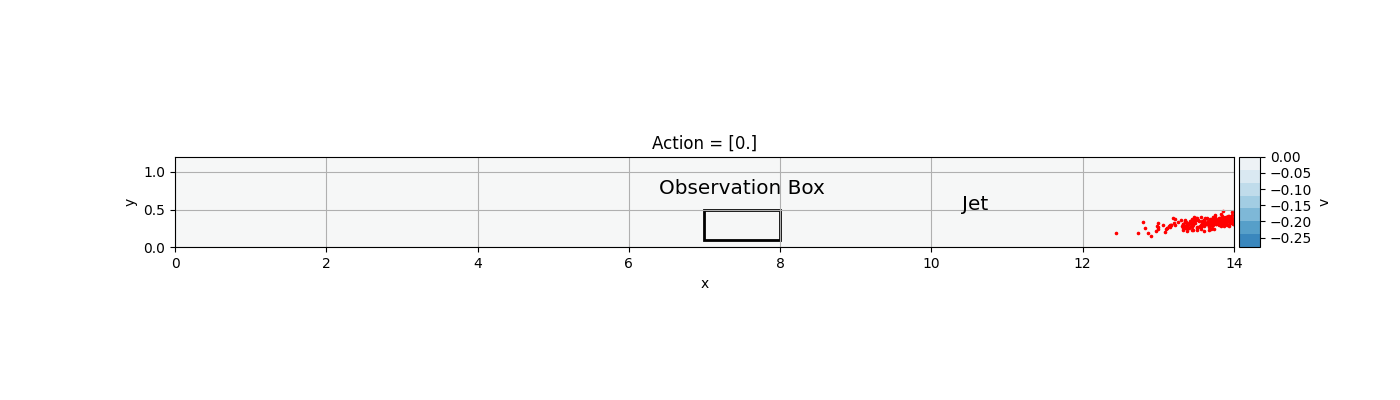

In [158]:
np.random.seed(17)

env = MultipleParticlesInFlowContinuous(config=env_config)
# test_and_plot(env, trainer_ppo_lstm_cont.compute_single_action, lstm=True)
test_and_animate(env, trainer_ppo_lstm_cont.compute_single_action, lstm=True, save_as="ppo_lstm_continuous")


## PPO + LSTM - Discrete

In [159]:
env_config = global_env_config.copy()

torch.manual_seed(random_seed)
np.random.seed(random_seed)

lstm_cell_size = 16
trainer_ppo_lstm_disc = PPOTrainer(
    config={
        "env": MultipleParticlesInFlowDiscrete,
        "env_config": env_config,
        "framework": "torch",
        "train_batch_size": 2*1024,
        "callbacks": MyCallbacks,
        # Parallel rollouts
#         "num_workers": 8,
        "num_gpus": 1,
        "lr": 0.00005,
        "clip_param": 0.99,
        "log_level": "INFO",
        "model": {
            "use_lstm": True,
            "lstm_cell_size": lstm_cell_size,
            "lstm_use_prev_action": False,
            "lstm_use_prev_reward": False,
            "max_seq_len": 40,
            "fcnet_hiddens": [256, 256],
        },
    }
)

train_reward_hist_lstm_disc = []
train_downwash_hist_lstm_disc = []
train_actuation_hist_lstm_disc = []
train_episodes_total_lstm_disc = []

2022-05-08 13:56:56,338	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 13:56:56,338	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=16453) 2022-05-08 13:56:57,877	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=16453) 2022-05-08 13:56:57,877	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps

In [160]:
trainer_ppo_lstm_disc.load_checkpoint('ray_results/ppo_lstm_discrete_act_cost_10_n_cells_1_1/checkpoint-200')

Played 1 episode; total-reward=833.3021525366207; Number of steps: 160


<IPython.core.display.Javascript object>


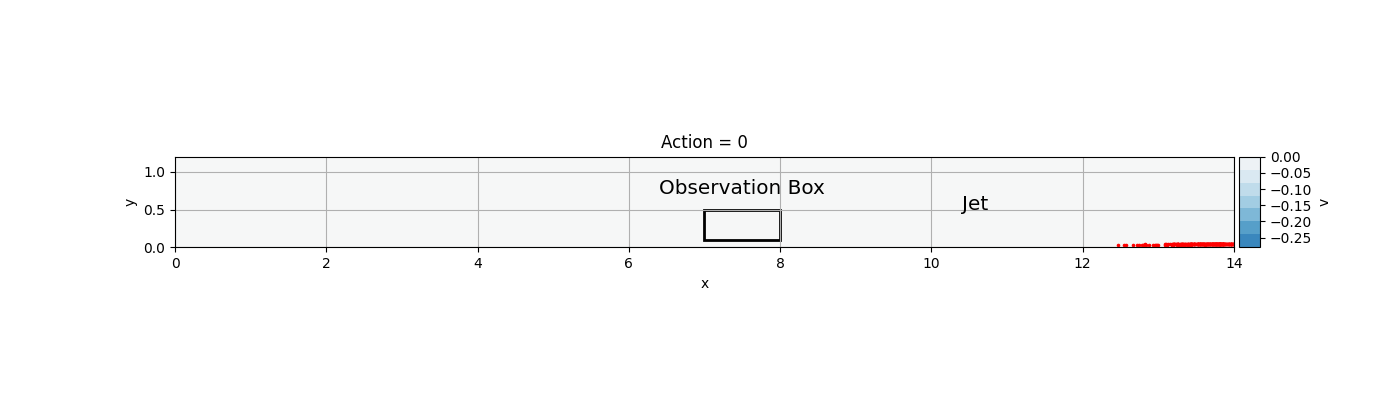

In [161]:
np.random.seed(17)
env = MultipleParticlesInFlowDiscrete(config=env_config)
# test_and_plot(env, trainer_ppo_lstm_disc.compute_single_action, lstm=True)
test_and_animate(env, trainer_ppo_lstm_disc.compute_single_action, lstm=True, save_as="ppo_lstm_discrete")

## PPO + Delay - Continuous

In [162]:
env_config = global_env_config.copy()
env_config.update({"hist_len_min": 10, "hist_len_max": 40})

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# lstm_cell_size = 8
trainer_ppo_delay_cont = PPOTrainer(
    config={
        "env": MultipleParticlesInFlowDelayedObsContinuous,
        "env_config": env_config,
        "framework": "torch",
        "callbacks": MyCallbacks,
        "train_batch_size": 2*1024,
        # Parallel rollouts
#         "num_workers": 8,
        "num_gpus": 1,
        "lr": 0.0001,
#         "gamma": 0.9,
        "clip_param": 0.9,
        "log_level": "INFO",
        "model": {
            "fcnet_activation": "relu",
            "fcnet_hiddens": [256, 256],
        },
    }
)

train_reward_hist_delay_cont = []
train_downwash_hist_delay_cont = []
train_actuation_hist_delay_cont = []
train_episodes_total_delay_cont = []

2022-05-08 13:57:40,215	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 13:57:40,216	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=16555) 2022-05-08 13:57:41,870	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=16555) 2022-05-08 13:57:41,870	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps

In [163]:
trainer_ppo_delay_cont.load_checkpoint('ray_results/ppo_delay_continuous_act_cost_10_n_cells_1_1/checkpoint-200')

Played 1 episode; total-reward=531.3539366242105; Number of steps: 149


<IPython.core.display.Javascript object>


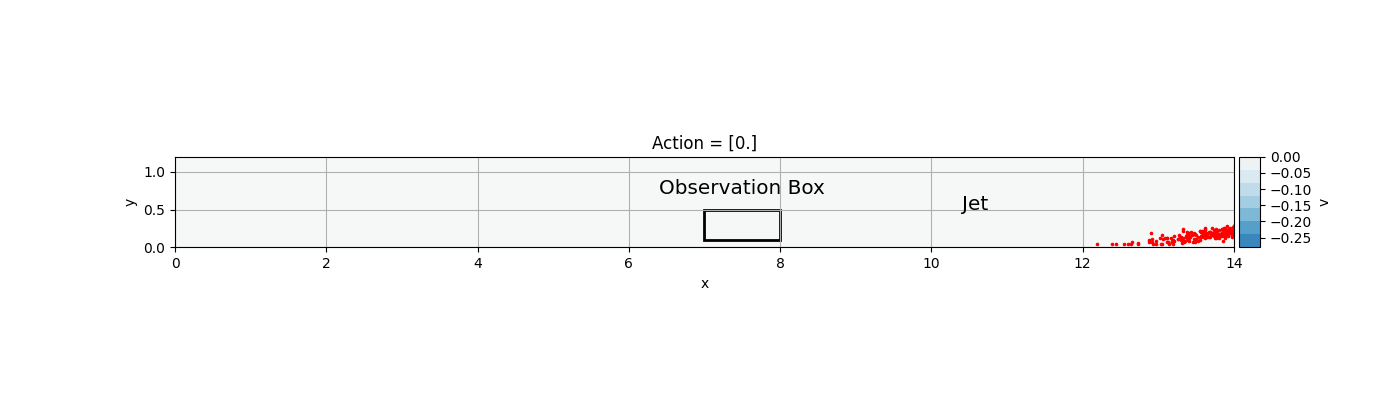

In [164]:
np.random.seed(17)
env = MultipleParticlesInFlowDelayedObsContinuous(config=env_config)
# test_and_plot(env, trainer_ppo_delay_cont.compute_single_action, lstm=False)
test_and_animate(env, trainer_ppo_delay_cont.compute_single_action, lstm=False, save_as="ppo_delay_continuous")

## PPO + Delay - Discrete

In [165]:
env_config = global_env_config.copy()
env_config.update({"hist_len_min": 10, "hist_len_max": 40})

torch.manual_seed(random_seed)
np.random.seed(random_seed)

trainer_ppo_delay_disc = PPOTrainer(
    config={
        "env": MultipleParticlesInFlowDelayedObsDiscrete,
        "env_config": env_config,
        "framework": "torch",
        "callbacks": MyCallbacks,
        "train_batch_size": 2*1024,
        # Parallel rollouts
#         "num_workers": 8,
        "num_gpus": 1,
        "lr": 0.0001,
        "clip_param": 0.9,
        "log_level": "INFO",
        "model": {
            "fcnet_activation": "relu",
            "fcnet_hiddens": [256, 256],
        },
    }
)

train_reward_hist_delay_disc = []
train_downwash_hist_delay_disc = []
train_actuation_hist_delay_disc = []
train_episodes_total_delay_disc = []

2022-05-08 13:58:25,100	WARNING ppo.py:240 -- `train_batch_size` (2048) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 1024.
2022-05-08 13:58:25,101	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-08 13:58:26,710	INFO worker_set.py:154 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.], (30,), float64), Discrete(2)), '__env__': (Box([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

In [166]:
trainer_ppo_delay_disc.load_checkpoint('ray_results/ppo_delay_discrete_act_cost_10_n_cells_1_1/checkpoint-200')

Played 1 episode; total-reward=835.5736076055806; Number of steps: 158


<IPython.core.display.Javascript object>


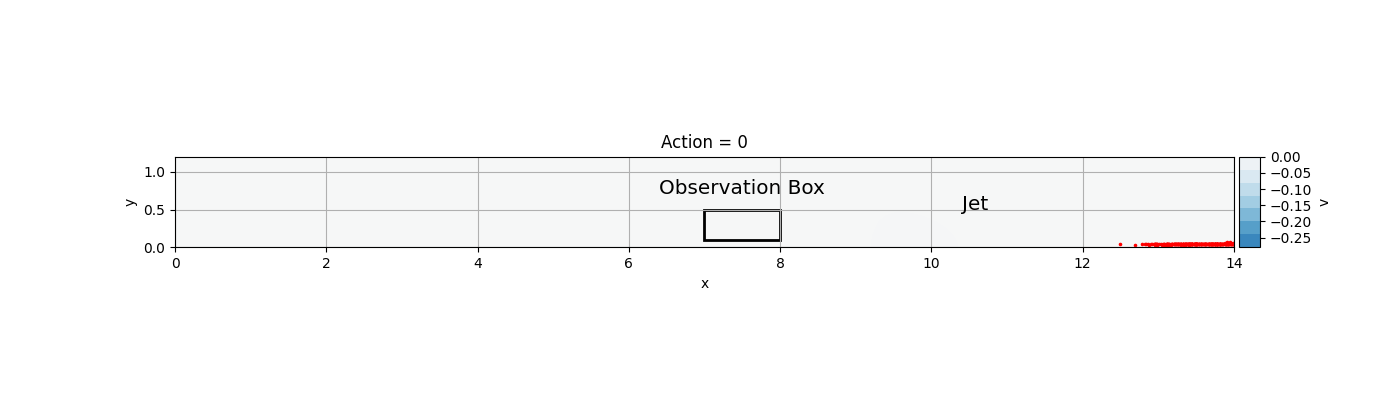

In [167]:
np.random.seed(17)
env = MultipleParticlesInFlowDelayedObsDiscrete(config=env_config)
# test_and_plot(env, trainer_ppo_delay_disc.compute_single_action, lstm=False)
test_and_animate(env, trainer_ppo_delay_disc.compute_single_action, lstm=False, save_as="ppo_delay_discrete")

# LSTM vs Delay | Continuous vs Discrete

### act_cost_weight = 10 | n_cells [1,1]

In [27]:
N = 200

In [28]:
ppo_lstm_continuous_results = [pickle.load(open(f"ray_results/ppo_lstm_continuous_act_cost_10_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(101,104)]
ppo_lstm_continuous_episodes = ppo_lstm_continuous_results[0]["train_episodes"][:N]
ppo_lstm_continuous_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_lstm_continuous_results)),axis=0)
ppo_lstm_continuous_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_lstm_continuous_results)),axis=0)
ppo_lstm_continuous_downwash_mean = np.mean(np.vstack((d["train_downwash"][:N] for d in ppo_lstm_continuous_results)),axis=0)
ppo_lstm_continuous_downwash_std = np.std(np.vstack((d["train_downwash"][:N] for d in ppo_lstm_continuous_results)),axis=0)
ppo_lstm_continuous_actuation_mean = np.mean(np.vstack((d["train_actuation"][:N] for d in ppo_lstm_continuous_results)),axis=0)
ppo_lstm_continuous_actuation_std = np.std(np.vstack((d["train_actuation"][:N] for d in ppo_lstm_continuous_results)),axis=0)

/tmp/ipykernel_10588/2221362076.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_continuous_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_lstm_continuous_results)),axis=0)
/tmp/ipykernel_10588/2221362076.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_continuous_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_lstm_continuous_results)),axis=0)
/tmp/ipykernel_10588/2221362076.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future

In [33]:
ppo_lstm_discrete_results = [pickle.load(open(f"ray_results/ppo_lstm_discrete_act_cost_10_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,105)]
ppo_lstm_discrete_episodes = ppo_lstm_discrete_results[0]["train_episodes"][:N]
ppo_lstm_discrete_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_lstm_discrete_results)),axis=0)
ppo_lstm_discrete_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_lstm_discrete_results)),axis=0)
ppo_lstm_discrete_downwash_mean = np.mean(np.vstack((d["train_downwash"][:N] for d in ppo_lstm_discrete_results)),axis=0)
ppo_lstm_discrete_downwash_std = np.std(np.vstack((d["train_downwash"][:N] for d in ppo_lstm_discrete_results)),axis=0)
ppo_lstm_discrete_actuation_mean = np.mean(np.vstack((d["train_actuation"][:N] for d in ppo_lstm_discrete_results)),axis=0)
ppo_lstm_discrete_actuation_std = np.std(np.vstack((d["train_actuation"][:N] for d in ppo_lstm_discrete_results)),axis=0)

/tmp/ipykernel_10588/2333129766.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_lstm_discrete_results)),axis=0)
/tmp/ipykernel_10588/2333129766.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_lstm_discrete_results)),axis=0)
/tmp/ipykernel_10588/2333129766.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_

In [34]:
ppo_delay_continuous_results = [pickle.load(open(f"ray_results/ppo_delay_continuous_act_cost_10_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,104)]
ppo_delay_continuous_episodes = ppo_delay_continuous_results[0]["train_episodes"][:N]
ppo_delay_continuous_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_delay_continuous_results)),axis=0)
ppo_delay_continuous_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_delay_continuous_results)),axis=0)
ppo_delay_continuous_downwash_mean = np.mean(np.vstack((d["train_downwash"][:N] for d in ppo_delay_continuous_results)),axis=0)
ppo_delay_continuous_downwash_std = np.std(np.vstack((d["train_downwash"][:N] for d in ppo_delay_continuous_results)),axis=0)
ppo_delay_continuous_actuation_mean = np.mean(np.vstack((d["train_actuation"][:N] for d in ppo_delay_continuous_results)),axis=0)
ppo_delay_continuous_actuation_std = np.std(np.vstack((d["train_actuation"][:N] for d in ppo_delay_continuous_results)),axis=0)

/tmp/ipykernel_10588/71596234.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_delay_continuous_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_delay_continuous_results)),axis=0)
/tmp/ipykernel_10588/71596234.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_delay_continuous_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_delay_continuous_results)),axis=0)
/tmp/ipykernel_10588/71596234.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [35]:
ppo_delay_discrete_results = [pickle.load(open(f"ray_results/ppo_delay_discrete_act_cost_10_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,104)]
ppo_delay_discrete_episodes = ppo_delay_discrete_results[0]["train_episodes"][:N]
ppo_delay_discrete_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_delay_discrete_results)),axis=0)
ppo_delay_discrete_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_delay_discrete_results)),axis=0)
ppo_delay_discrete_downwash_mean = np.mean(np.vstack((d["train_downwash"][:N] for d in ppo_delay_discrete_results)),axis=0)
ppo_delay_discrete_downwash_std = np.std(np.vstack((d["train_downwash"][:N] for d in ppo_delay_discrete_results)),axis=0)
ppo_delay_discrete_actuation_mean = np.mean(np.vstack((d["train_actuation"][:N] for d in ppo_delay_discrete_results)),axis=0)
ppo_delay_discrete_actuation_std = np.std(np.vstack((d["train_actuation"][:N] for d in ppo_delay_discrete_results)),axis=0)

/tmp/ipykernel_10588/254987162.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_delay_discrete_reward_mean = np.mean(np.vstack((d["train_reward"][:N] for d in ppo_delay_discrete_results)),axis=0)
/tmp/ipykernel_10588/254987162.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_delay_discrete_reward_std = np.std(np.vstack((d["train_reward"][:N] for d in ppo_delay_discrete_results)),axis=0)
/tmp/ipykernel_10588/254987162.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo

<IPython.core.display.Javascript object>


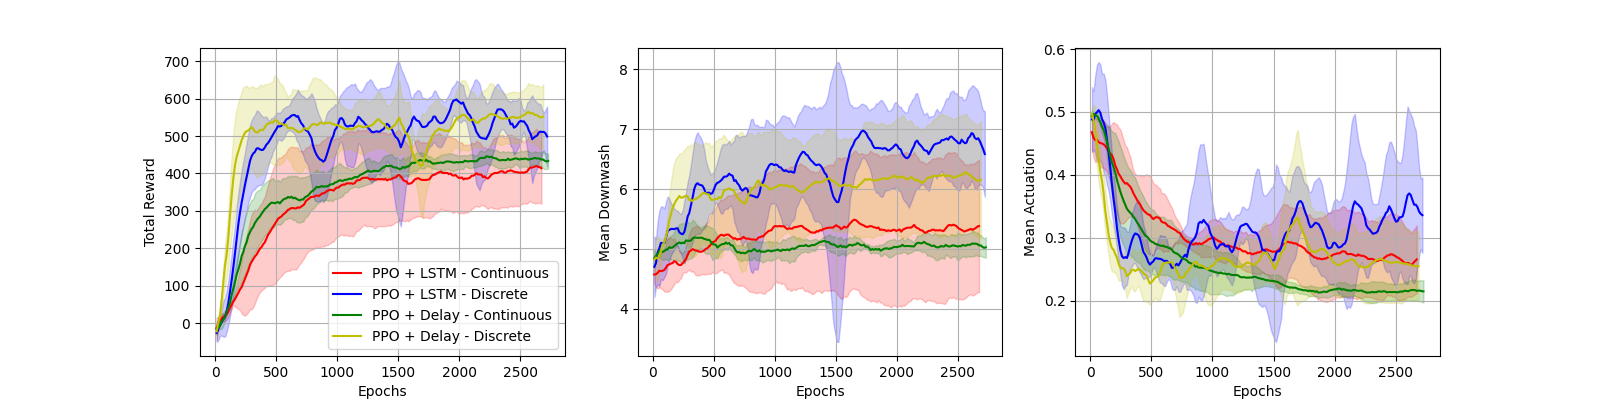

In [178]:
fig = plt.figure(figsize=[16,4])

# Reward
ax = fig.add_subplot(131)
ax.plot(ppo_lstm_continuous_episodes, ppo_lstm_continuous_reward_mean, c='r', label='PPO + LSTM - Continuous')
ax.fill_between(ppo_lstm_continuous_episodes, 
                ppo_lstm_continuous_reward_mean - ppo_lstm_continuous_reward_std, 
                ppo_lstm_continuous_reward_mean + ppo_lstm_continuous_reward_std,
                color='r', alpha=0.2)
ax.plot(ppo_lstm_discrete_episodes, ppo_lstm_discrete_reward_mean, c='b', label='PPO + LSTM - Discrete')
ax.fill_between(ppo_lstm_discrete_episodes, 
                ppo_lstm_discrete_reward_mean - ppo_lstm_discrete_reward_std, 
                ppo_lstm_discrete_reward_mean + ppo_lstm_discrete_reward_std,
                color='b', alpha=0.2)
ax.plot(ppo_delay_continuous_episodes, ppo_delay_continuous_reward_mean, c='g', label='PPO + Delay - Continuous')
ax.fill_between(ppo_delay_continuous_episodes, 
                ppo_delay_continuous_reward_mean - ppo_delay_continuous_reward_std, 
                ppo_delay_continuous_reward_mean + ppo_delay_continuous_reward_std,
                color='g', alpha=0.2)
ax.plot(ppo_delay_discrete_episodes, ppo_delay_discrete_reward_mean, c='y', label='PPO + Delay - Discrete')
ax.fill_between(ppo_delay_discrete_episodes, 
                ppo_delay_discrete_reward_mean - ppo_delay_discrete_reward_std, 
                ppo_delay_discrete_reward_mean + ppo_delay_discrete_reward_std,
                color='y', alpha=0.2)
ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Reward")

# Downwash
ax = fig.add_subplot(132)
ax.plot(ppo_lstm_continuous_episodes[:N], ppo_lstm_continuous_downwash_mean[:N], c='r', label='PPO + LSTM - Continuous')
ax.fill_between(ppo_lstm_continuous_episodes[:N], 
                ppo_lstm_continuous_downwash_mean[:N] - ppo_lstm_continuous_downwash_std[:N], 
                ppo_lstm_continuous_downwash_mean[:N] + ppo_lstm_continuous_downwash_std[:N],
                color='r', alpha=0.2)
ax.plot(ppo_lstm_discrete_episodes, ppo_lstm_discrete_downwash_mean, c='b', label='PPO + LSTM - Discrete')
ax.fill_between(ppo_lstm_discrete_episodes, 
                ppo_lstm_discrete_downwash_mean - ppo_lstm_discrete_downwash_std, 
                ppo_lstm_discrete_downwash_mean + ppo_lstm_discrete_downwash_std,
                color='b', alpha=0.2)
ax.plot(ppo_delay_continuous_episodes, ppo_delay_continuous_downwash_mean, c='g', label='PPO + Delay - Continuous')
ax.fill_between(ppo_delay_continuous_episodes, 
                ppo_delay_continuous_downwash_mean - ppo_delay_continuous_downwash_std, 
                ppo_delay_continuous_downwash_mean + ppo_delay_continuous_downwash_std,
                color='g', alpha=0.2)
ax.plot(ppo_delay_discrete_episodes, ppo_delay_discrete_downwash_mean, c='y', label='PPO + Delay - Discrete')
ax.fill_between(ppo_delay_discrete_episodes, 
                ppo_delay_discrete_downwash_mean - ppo_delay_discrete_downwash_std, 
                ppo_delay_discrete_downwash_mean + ppo_delay_discrete_downwash_std,
                color='y', alpha=0.2)
# ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Downwash")

# Downwash
ax = fig.add_subplot(133)
ax.plot(ppo_lstm_continuous_episodes[:N], ppo_lstm_continuous_actuation_mean[:N], c='r', label='PPO + LSTM - Continuous')
ax.fill_between(ppo_lstm_continuous_episodes[:N], 
                ppo_lstm_continuous_actuation_mean[:N] - ppo_lstm_continuous_actuation_std[:N], 
                ppo_lstm_continuous_actuation_mean[:N] + ppo_lstm_continuous_actuation_std[:N],
                color='r', alpha=0.2)
ax.plot(ppo_lstm_discrete_episodes, ppo_lstm_discrete_actuation_mean, c='b', label='PPO + LSTM - Discrete')
ax.fill_between(ppo_lstm_discrete_episodes, 
                ppo_lstm_discrete_actuation_mean - ppo_lstm_discrete_actuation_std, 
                ppo_lstm_discrete_actuation_mean + ppo_lstm_discrete_actuation_std,
                color='b', alpha=0.2)
ax.plot(ppo_delay_continuous_episodes, ppo_delay_continuous_actuation_mean, c='g', label='PPO + Delay - Continuous')
ax.fill_between(ppo_delay_continuous_episodes, 
                ppo_delay_continuous_actuation_mean - ppo_delay_continuous_actuation_std, 
                ppo_delay_continuous_actuation_mean + ppo_delay_continuous_actuation_std,
                color='g', alpha=0.2)
ax.plot(ppo_delay_discrete_episodes, ppo_delay_discrete_actuation_mean, c='y', label='PPO + Delay - Discrete')
ax.fill_between(ppo_delay_discrete_episodes, 
                ppo_delay_discrete_actuation_mean - ppo_delay_discrete_actuation_std, 
                ppo_delay_discrete_actuation_mean + ppo_delay_discrete_actuation_std,
                color='y', alpha=0.2)
# ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Actuation")

plt.savefig("comparisons_lstm_delay_continuous_discrete.pdf")

# PPO + LSTM with Discrete Actions

In [172]:
ppo_lstm_discrete_4_results = [pickle.load(open(f"ray_results/ppo_lstm_discrete_act_cost_1_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,104)]
ppo_lstm_discrete_4_episodes = ppo_lstm_discrete_4_results[0]["train_episodes"]
ppo_lstm_discrete_4_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_4_results)),axis=0)
ppo_lstm_discrete_4_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_4_results)),axis=0)
ppo_lstm_discrete_4_downwash_mean = np.mean(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_4_results)),axis=0)
ppo_lstm_discrete_4_downwash_std = np.std(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_4_results)),axis=0)
ppo_lstm_discrete_4_actuation_mean = np.mean(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_4_results)),axis=0)
ppo_lstm_discrete_4_actuation_std = np.std(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_4_results)),axis=0)

/tmp/ipykernel_10588/2040516507.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_4_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_4_results)),axis=0)
/tmp/ipykernel_10588/2040516507.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_4_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_4_results)),axis=0)
/tmp/ipykernel_10588/2040516507.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_

In [173]:
ppo_lstm_discrete_1_results = [pickle.load(open(f"ray_results/ppo_lstm_discrete_act_cost_5_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,105)]
ppo_lstm_discrete_1_episodes = ppo_lstm_discrete_1_results[0]["train_episodes"]
ppo_lstm_discrete_1_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_1_results)),axis=0)
ppo_lstm_discrete_1_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_1_results)),axis=0)
ppo_lstm_discrete_1_downwash_mean = np.mean(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_1_results)),axis=0)
ppo_lstm_discrete_1_downwash_std = np.std(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_1_results)),axis=0)
ppo_lstm_discrete_1_actuation_mean = np.mean(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_1_results)),axis=0)
ppo_lstm_discrete_1_actuation_std = np.std(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_1_results)),axis=0)

/tmp/ipykernel_10588/1517464562.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_1_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_1_results)),axis=0)
/tmp/ipykernel_10588/1517464562.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_1_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_1_results)),axis=0)
/tmp/ipykernel_10588/1517464562.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_

In [174]:
ppo_lstm_discrete_2_results = [pickle.load(open(f"ray_results/ppo_lstm_discrete_act_cost_10_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,104)]
ppo_lstm_discrete_2_episodes = ppo_lstm_discrete_2_results[0]["train_episodes"]
ppo_lstm_discrete_2_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_2_results)),axis=0)
ppo_lstm_discrete_2_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_2_results)),axis=0)
ppo_lstm_discrete_2_downwash_mean = np.mean(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_2_results)),axis=0)
ppo_lstm_discrete_2_downwash_std = np.std(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_2_results)),axis=0)
ppo_lstm_discrete_2_actuation_mean = np.mean(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_2_results)),axis=0)
ppo_lstm_discrete_2_actuation_std = np.std(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_2_results)),axis=0)

/tmp/ipykernel_10588/1569087633.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_2_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_2_results)),axis=0)
/tmp/ipykernel_10588/1569087633.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_2_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_2_results)),axis=0)
/tmp/ipykernel_10588/1569087633.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_

In [175]:
ppo_lstm_discrete_3_results = [pickle.load(open(f"ray_results/ppo_lstm_discrete_act_cost_20_n_cells_1_1/train_results_{d}.pkl", 'rb')) for d in range(100,104)]
ppo_lstm_discrete_3_episodes = ppo_lstm_discrete_3_results[0]["train_episodes"]
ppo_lstm_discrete_3_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_3_results)),axis=0)
ppo_lstm_discrete_3_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_3_results)),axis=0)
ppo_lstm_discrete_3_downwash_mean = np.mean(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_3_results)),axis=0)
ppo_lstm_discrete_3_downwash_std = np.std(np.vstack((d["train_downwash"] for d in ppo_lstm_discrete_3_results)),axis=0)
ppo_lstm_discrete_3_actuation_mean = np.mean(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_3_results)),axis=0)
ppo_lstm_discrete_3_actuation_std = np.std(np.vstack((d["train_actuation"] for d in ppo_lstm_discrete_3_results)),axis=0)

/tmp/ipykernel_10588/3139146749.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_3_reward_mean = np.mean(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_3_results)),axis=0)
/tmp/ipykernel_10588/3139146749.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_lstm_discrete_3_reward_std = np.std(np.vstack((d["train_reward"] for d in ppo_lstm_discrete_3_results)),axis=0)
/tmp/ipykernel_10588/3139146749.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ppo_

## Plot

<IPython.core.display.Javascript object>


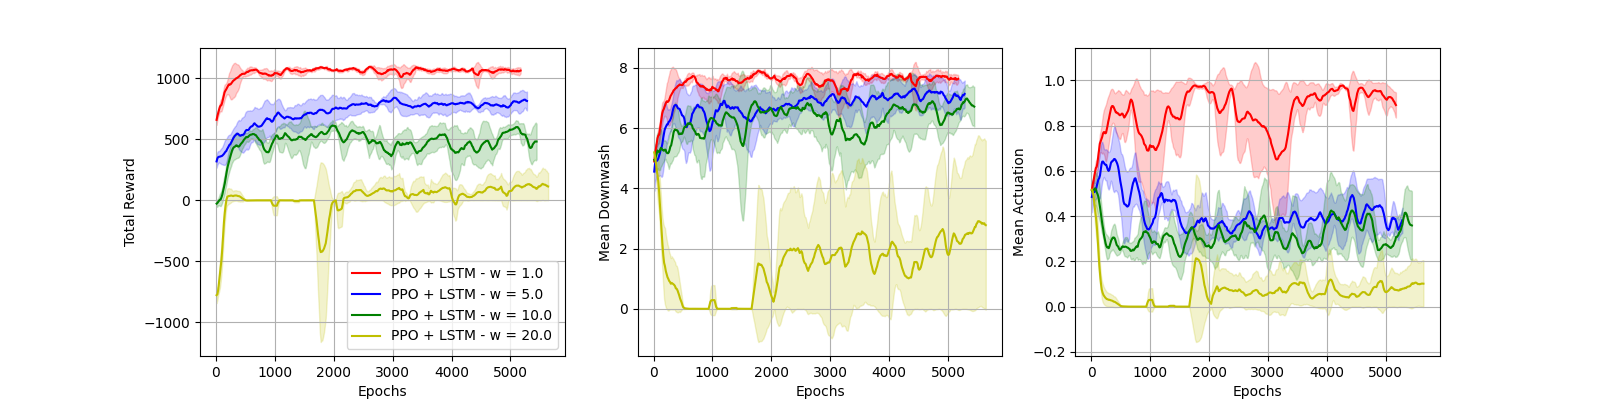

In [179]:
fig = plt.figure(figsize=[16,4])

def plot_mean_and_std(ax, x, y_mean, y_std, label="Label", c='k'):
    ax.plot(x, y_mean, c=c, label=label)
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=c, alpha=0.2)
    return ax

# Reward
ax = fig.add_subplot(131)
plot_mean_and_std(ax, ppo_lstm_discrete_4_episodes, ppo_lstm_discrete_4_reward_mean, ppo_lstm_discrete_4_reward_std,
                 label='PPO + LSTM - w = 1.0', c='r')
plot_mean_and_std(ax, ppo_lstm_discrete_1_episodes, ppo_lstm_discrete_1_reward_mean, ppo_lstm_discrete_1_reward_std,
                 label='PPO + LSTM - w = 5.0', c='b')
plot_mean_and_std(ax, ppo_lstm_discrete_2_episodes, ppo_lstm_discrete_2_reward_mean, ppo_lstm_discrete_2_reward_std,
                 label='PPO + LSTM - w = 10.0', c='g')
plot_mean_and_std(ax, ppo_lstm_discrete_3_episodes, ppo_lstm_discrete_3_reward_mean, ppo_lstm_discrete_3_reward_std,
                 label='PPO + LSTM - w = 20.0', c='y')

ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Reward")

# Downwash
ax = fig.add_subplot(132)
plot_mean_and_std(ax, ppo_lstm_discrete_4_episodes, ppo_lstm_discrete_4_downwash_mean, ppo_lstm_discrete_4_downwash_std,
                 label='PPO + LSTM - w = 1.0', c='r')
plot_mean_and_std(ax, ppo_lstm_discrete_1_episodes, ppo_lstm_discrete_1_downwash_mean, ppo_lstm_discrete_1_downwash_std,
                 label='PPO + LSTM - w = 5.0', c='b')
plot_mean_and_std(ax, ppo_lstm_discrete_2_episodes, ppo_lstm_discrete_2_downwash_mean, ppo_lstm_discrete_2_downwash_std,
                 label='PPO + LSTM - w = 10.0', c='g')
plot_mean_and_std(ax, ppo_lstm_discrete_3_episodes, ppo_lstm_discrete_3_downwash_mean, ppo_lstm_discrete_3_downwash_std,
                 label='PPO + LSTM - w = 20.0', c='y')

# ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Downwash")

# Downwash
ax = fig.add_subplot(133)
plot_mean_and_std(ax, ppo_lstm_discrete_4_episodes, ppo_lstm_discrete_4_actuation_mean, ppo_lstm_discrete_4_actuation_std,
                 label='PPO + LSTM - w = 1.0', c='r')
plot_mean_and_std(ax, ppo_lstm_discrete_1_episodes, ppo_lstm_discrete_1_actuation_mean, ppo_lstm_discrete_1_actuation_std,
                 label='PPO + LSTM - w = 5.0', c='b')
plot_mean_and_std(ax, ppo_lstm_discrete_2_episodes, ppo_lstm_discrete_2_actuation_mean, ppo_lstm_discrete_2_actuation_std,
                 label='PPO + LSTM - w = 10.0', c='g')
plot_mean_and_std(ax, ppo_lstm_discrete_3_episodes, ppo_lstm_discrete_3_actuation_mean, ppo_lstm_discrete_3_actuation_std,
                 label='PPO + LSTM - w = 20.0', c='y')

# ax.legend()
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Actuation")

plt.savefig("comparisons_lstm_discrete_actuation_weights.pdf")